In [ ]:
#install the nltools module
!pip install nltools
!pip install pingouin


In [ ]:
#install all modules required to perform ISC, ISRA, functional hyperalignment analyses
%matplotlib inline

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length, fisher_r_to_z, correlation_permutation
from nilearn.plotting import view_img_on_surf, view_img, plot_glass_brain, plot_stat_map
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp, rankdata, ttest_rel
from scipy.signal import hilbert
from sklearn.manifold import TSNE
import networkx as nx
from IPython.display import HTML
from nilearn import plotting
from nilearn import signal
from nilearn import regions
import nibabel as nib


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Load the NARSAD timeseries

In [ ]:
#read the timeseries of all neurotypical youths and adolescents suffering from depressive symptoms into a 3D array

data_dir = np.sort(glob.glob('/content/drive/MyDrive/Year2/NARSAD3/*_task-thepresent_nuisance_regressed_shen_2mm_268.txt'))
sub_list = [os.path.basename(x).split('_')[0] for x in data_dir]

timeseries = []
sub_timeseries = {}

for filename in data_dir:

  shen = np.loadtxt(filename)
  shen_df = pd.DataFrame(shen)
  shen_df.reset_index(inplace = True, drop = True)
  shen_df_to_array = shen_df.to_numpy()
  timeseries.append(shen_df_to_array)

timeseries_3D = np.array(timeseries)


In [ ]:
#standardise the timeseries by z-transforming the timesries and store it in a dataframe

standardise_df = {}
timeseries_reg = {}

for sub in range(timeseries_3D.shape[0]):

  standardise_df[sub] = signal.clean(timeseries_3D[sub, :, :], detrend = False, standardize = 'zscore', standardize_confounds = False, t_r = None)
  timeseries_reg[sub] = pd.DataFrame(standardise_df[sub])


In [ ]:
timeseries_array = []

for sub in range(len(sub_list)):

  timeseries = timeseries_reg[sub].to_numpy()
  timeseries_array.append(timeseries)

timeseries_array = np.array(timeseries_array)


## Load the behavioural measures

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


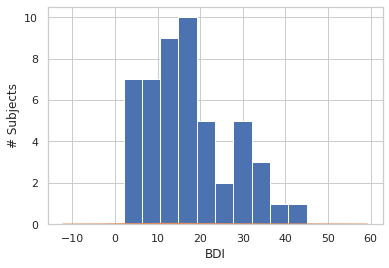

In [ ]:
#load the behavioural measures: (1) BDI-Y which assessed the severity of depressive symptoms in youths - (2) CERQ which measured the cognitive emotional regulation in adolescents

behav_data_BDI = pd.read_csv('/content/drive/MyDrive/Year2/behav_narsad_data.csv')
behav_data_CERQ = pd.read_csv('/content/drive/MyDrive/Year2/maladaptive_strategy_CERQ.csv')

behav = behav_data_BDI["BDI"]
plt.hist(behav)
plt.xlabel('CERQ Scores')
plt.ylabel('# Subjects')
sns.distplot(behav)

behav_rank = rankdata(behav)


## FC Analysis

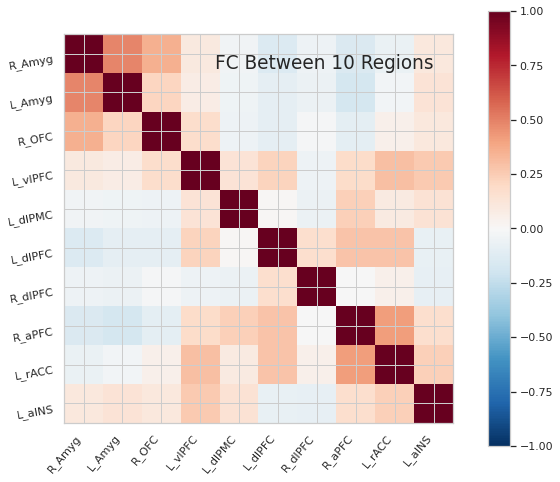

In [ ]:
from nilearn.connectome import ConnectivityMeasure

cm = ConnectivityMeasure(kind = 'correlation')
correlations = []

rois = ['R_Amyg', 'L_Amyg', 'R_OFC', 'L_vlPFC', 'L_dlPMC', 'L_dlPFC', 'R_dlPFC', 'R_aPFC', 'L_rACC', 'L_aINS']
neurosynth = [99, 231, 18, 151, 162, 149, 14, 144, 219, 169]
neuro_roi_index = [98, 230, 17, 150, 161, 148, 13, 143, 218, 168]

timeseries_neurosynth = np.take(timeseries_array, neuro_roi_index, axis = 2)

for i in range(timeseries_neurosynth.shape[0]):

  corr_mat = cm.fit_transform([timeseries_neurosynth[i, :, :]])
  correlations.append(corr_mat)

corr = np.squeeze(np.array(correlations))

mean_correlations = np.mean(corr, axis = 0).reshape(corr.shape[1], corr.shape[1])
plotting.plot_matrix(mean_correlations, vmax = 1, vmin = -1, colorbar = True, title = 'FC Between 10 Regions', labels = rois, figure = (8,10))

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})


In [ ]:
from nilearn.connectome import ConnectivityMeasure

cm = ConnectivityMeasure(kind = 'correlation', vectorize = True, discard_diagonal = True)
correlations = []

rois = ['R_Amyg', 'L_Amyg', 'R_OFC', 'L_vlPFC', 'L_dlPMC', 'L_dlPFC', 'R_dlPFC', 'R_aPFC', 'L_rACC', 'L_aINS']
neurosynth = [99, 231, 18, 151, 162, 149, 14, 144, 219, 169]
neuro_roi_index = [98, 230, 17, 150, 161, 148, 13, 143, 218, 168]

timeseries_neurosynth = np.take(timeseries_array, neuro_roi_index, axis = 2)

for i in range(timeseries_neurosynth.shape[0]):

  corr_mat = cm.fit_transform([timeseries_neurosynth[i, :, :]])
  correlations.append(corr_mat)

corr = np.squeeze(np.array(correlations))

mean_r, mean_p = {}, {}

for edge in range(corr.shape[1]):

  stats = correlation_permutation(corr[:, edge], behav, method = 'permute', n_permute = 5000, metric = 'spearman', n_jobs = -1, return_perms = False, random_state = None)
  mean_r[edge], mean_p[edge] = stats['correlation'], stats['p']


In [ ]:
p_val = np.array(list(mean_p.items()))
p_val_fdr = p_val[:, 1]
fdr(p_val_fdr)

import statsmodels as sm
sm.stats.multitest.fdrcorrection(p_val_fdr, alpha = 0.05, method = 'i', is_sorted = False)


## Tapered Cosine Sliding Window

Text(0.5, 0, 'Sample')

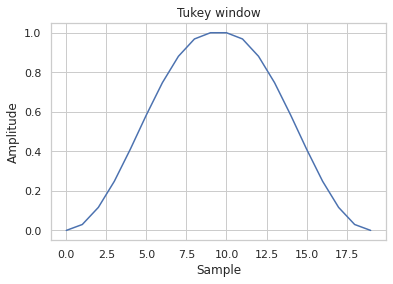

In [ ]:
#compute the weights from a tapered cosine sliding window (Tukey window) as described by Gruskin et al., 2020

from scipy import signal
window = signal.windows.tukey(20, alpha = 0.95, sym = True)
plt.plot(window)
plt.title("Tukey window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")


## Dynamic FC using Sliding Window (width = 20 TR)

In [ ]:
from nilearn.connectome import ConnectivityMeasure

cm = ConnectivityMeasure(kind = 'correlation', vectorize = True, discard_diagonal = True)

rois = ['R_Amyg', 'L_Amyg', 'R_OFC', 'L_vlPFC', 'L_dlPMC', 'L_dlPFC', 'R_dlPFC', 'R_aPFC', 'L_rACC', 'L_aINS']
neurosynth = [99, 231, 18, 151, 162, 149, 14, 144, 219, 169]
neuro_roi_index = [98, 230, 17, 150, 161, 148, 13, 143, 218, 168]

timeseries_neurosynth = np.take(timeseries_array, neuro_roi_index, axis = 2)

timeseries_reg_neurosynth = {}

for sub in range(timeseries_neurosynth.shape[0]):

  timeseries_reg_neurosynth[sub] = pd.DataFrame(timeseries_neurosynth[sub, :, :])


In [ ]:
#initialise number of subjects, timepoints and regions
n_subs, tp, nodes = timeseries_neurosynth.shape

#initialise number of sliding windows to compute dynamic FC
num_window = tp - window.shape[0]

#initialise TR with a step size of 1 which is consistent with Gruskin et al. (2020)
TR = np.arange(0, 20, 1)

#initialise the sliding timeseries
weighted_timeseries, slid_win_timeseries = np.zeros((n_subs, nodes, len(TR))), {}

#compute FC across the 10 ROIs as defined by 
FC_r, FC_p = {}, {}
FC_win_r, FC_win_p = {}, {}

correlations = np.zeros((n_subs, int(((nodes*nodes)-nodes)/2)))

for sliding in range(num_window):
  
  print(sliding)

  for sub in range(n_subs):

    
    for roi in range(nodes):

      #compute the weighted timeseries by multiplying the timeseries with the tapered cosine sliding window
      weighted = timeseries_reg_neurosynth[sub][min(TR):max(TR) + 1][roi] * window
      weighted_timeseries[sub, roi, :] = weighted
  
  for sub in range(weighted_timeseries.shape[0]):

    transmatrix = weighted_timeseries[sub, :, :].T
    corr_mat = cm.fit_transform([transmatrix])
    corr = np.squeeze(corr_mat)
    correlations[sub, :] = corr

  #compute FC for each sliding window
  for edge in range(correlations.shape[1]):
    
    stats = correlation_permutation(correlations[:, edge], behav, method = 'permute', n_permute = 5000, metric = 'spearman', n_jobs = -1, return_perms = False, random_state = None)
    FC_r[edge], FC_p[edge] = stats['correlation'], stats['p']

  #store all the FC and their p-values for each sliding window
  FC_win_r[sliding], FC_win_p[sliding] = pd.DataFrame([FC_r]), pd.DataFrame([FC_p])

  TR += 1
  print(TR)


0
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
1
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
2
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
3
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
4
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
5
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
6
[ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
7
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27]
8
[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]
9
[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
10
[11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
11
[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
12
[13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
13
[14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]
14
[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34]
15
[16 17 18 19 20 21 22 23 24 25 2

In [ ]:
y = {}

for i in range(num_window):

  y[i] = FC_win_r[i].squeeze().to_dict()
  
z = {}

for j in range(num_window):

  z[j] = FC_win_p[j].squeeze().to_dict()


In [ ]:
import json
FC_win_r_file = open("/content/drive/MyDrive/Year2/dFC_win_BDI_fullmovie_rval.json", "w")
json.dump(y, FC_win_r_file)
FC_win_r_file.close()

FC_win_p_file = open("/content/drive/MyDrive/Year2/dFC_win_BDI_fullmovie_pval.json", "w")
json.dump(z, FC_win_p_file)
FC_win_p_file.close()


In [ ]:
import json

temp_r = open("/content/drive/MyDrive/Year2/dFC_win_BDI_fullmovie_rval.json", "r")
dFC_R = json.loads(temp_r.read())

temp_p = open("/content/drive/MyDrive/Year2/dFC_win_BDI_fullmovie_pval.json", "r")
dFC_P = json.loads(temp_p.read())


In [ ]:
FC_window_r_df = pd.DataFrame(dFC_R)
FC_window_p_df = pd.DataFrame(dFC_P)

fdr_p = []
thr_p = []

for window in range(FC_window_r_df.shape[1]):

  rval = FC_window_r_df.iloc[:, window]
  rval.to_dict()
  
  pval = FC_window_p_df.iloc[:, window]
  pval.to_dict()
  
  thr = fdr(pd.Series(pval).values)
  fdr_p.append(thr)

  uncthr = (pd.Series(pval).values <= 0.01)
  thr_p.append(uncthr)

  print(pd.Series(pval).values)
  

In [ ]:
for window in range(FC_window_r_df.shape[1]):

  print(window)
  print(thr_p[window])
  print(np.where(thr_p[window] == True))
  

0
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False  True  True]
(array([36, 43, 44]),)
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False  True  True]
(array([36, 43, 44]),)
2
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
  True False False False False False False  True  True]
(array([31, 36, 43, 44]),)
3
[False False False False False False False False False False False False
 False False False Fa

In [ ]:
dFC_R['85']['26']

0.3894445360360417

In [ ]:
(0.38 + 0.44 + 0.44 + 0.42 + 0.41 + 0.38) / 6 #window = 66-71 for adaptive CERQ

0.4116666666666666

In [ ]:
(-0.37 - 0.45 - 0.46 - 0.46 - 0.44 - 0.45 - 0.41 - 0.37) / 8 #window = 31-38 for maladaptive CERQ
(-0.37 - 0.38 - 0.40 - 0.40 - 0.37) / 5 #window = 47-51 for maladaptive CERQ
(0.36 + 0.39 + 0.39 + 0.40 + 0.39 + 0.39) / 6 #window = 80-85 for maladaptive CERQ

0.3866666666666667